# Logistic Regression on Fatal Accidents

Fatal accidents take away more than 30,000 lives every year in the U.S.  [(NHTSA)](https://www-fars.nhtsa.dot.gov/Main/index.aspx), and traffic safety have been concern of many people for years. In our final project, we want to identify the most probable factors that affect accident severity. We are not aimming to examinate all fators due to limitation of data obtained from the accident report, but we will explore factors that we believe are more likely to lead to death, such as location, age, time, collision type, and alcohol involvement.
<br/>The data we use to perform Logitic Regression are [all traffic accidents happened in Allegheny County, City of Pittsburgh*](data/accident/allegheny-county-crash-data-dictionary.pdf) from 2004-2016. The accidents are classified as either fatal or nonfatal accidents, this binary response variable makes it suitable for logistic regression.

Source*: [DATA.GOV](https://catalog.data.gov/dataset/allegheny-county-crash-data)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
pd.set_option('display.max_columns', 200)
import warnings
warnings.filterwarnings('ignore')

/Users/huyuanfeng818/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


First we selected variables that we think are most probable facotrs that will lead to fatal accidents, and change their name and value according to [Allegheny County Crash Data dictionary](data/allegheny-county-crash-data-dictionary.pdf) to make them more readable.

In [15]:
# load crash data
raw = pd.read_csv('data/accident/Allegheny County Crash Data.csv')
# select variables 
crashs = raw[['FATAL','FATAL_OR_MAJ_INJ','COLLISION_TYPE','DAY_OF_WEEK','VEHICLE_COUNT','WEATHER','DRIVER_16YR','DRIVER_17YR','DRIVER_65_74YR','DRIVER_75PLUS','AGGRESSIVE_DRIVING','DISTRACTED','DRINKING_DRIVER','HVY_TRUCK_RELATED','INTERSECTION','SPEEDING_RELATED','UNBELTED','FIRE_IN_VEHICLE','CELL_PHONE','ILLUMINATION']]
crashs['COLLISION_TYPE'] = crashs['COLLISION_TYPE'].map({0.0:'Not Collision',1.0:'Rear-End',2.0:'Head-On',3.0:'Rear-to-Rear',4.0:'Angle',5:'Sideswipe',6:'Sideswipe',7:'Hit_Fixed_Object',8:'Hit Pedestrian',9.0:'Unknown'})
crashs['ILLUMINATION'] = crashs['ILLUMINATION'].map({1.0:'Daylight',2:'Dark,no_street_lights',3:'Dark,street_lights',4:'Dusk',5:'Dawn', 6:'Dark',8.0:'Not Report',9.0:'Not Report'})
crashs['DAY_OF_WEEK']= crashs['DAY_OF_WEEK'].map({1:'Weekend',7:'Weekend',2:'Weekday',3:'Weekday',4:'Weekday',5:'Weekday',6:'Weekday'})
crashs['WEATHER']= crashs['WEATHER'].map({1:'No_adverse_conditions',2:'Rain',3:'Sleet',4:'Snow',5:'Fog',6:'Rain_and_fog',7:'Sleet_and_fog',8:'other',9:'other'})
# see selected variable in the table
crashs.head()

,FATAL,FATAL_OR_MAJ_INJ,COLLISION_TYPE,DAY_OF_WEEK,VEHICLE_COUNT,WEATHER,DRIVER_16YR,DRIVER_17YR,DRIVER_65_74YR,DRIVER_75PLUS,AGGRESSIVE_DRIVING,DISTRACTED,DRINKING_DRIVER,HVY_TRUCK_RELATED,INTERSECTION,SPEEDING_RELATED,UNBELTED,FIRE_IN_VEHICLE,CELL_PHONE,ILLUMINATION
0,0,0,Hit_Fixed_Object,Weekday,1,No_adverse_conditions,0,0,0,0,0,1,1,0,0,0,1,0,0,"Dark,no_street_lights"
1,0,0,Hit_Fixed_Object,Weekday,1,No_adverse_conditions,0,0,0,0,0,0,0,0,0,0,0,0,0,Daylight
2,0,0,Hit_Fixed_Object,Weekday,1,No_adverse_conditions,0,0,0,0,1,0,0,0,1,0,0,0,0,"Dark,no_street_lights"
3,0,0,Angle,Weekday,2,No_adverse_conditions,0,0,1,0,1,0,0,1,1,0,0,0,0,Daylight
4,0,0,Rear-End,Weekday,2,No_adverse_conditions,1,0,0,0,0,0,0,0,0,0,0,0,0,"Dark,street_lights"


### Variables descriptions

**Predict variable:**<br/>
FATAL_OR_MAJ_INJ (1--Yes, 0--No)<br/>


**Input variable:**<br/>
`Countinous variables`:<br/>
VEHICLE_COUNT<br/>

`Non-dummy catagorical variables:`<br/>
COLLISION_TYPE<br/>
ILLUMINATION: light condition<br/>
WEATHER<br/>

`Dummy catagorical variables(1--Yes, 0--No):`<br/>
DAY_OF_WEEK: Weekday, Weekend<br/>
AGGRESSIVE_DRIVING<br/>
DISTRACTED<br/>
DRINKING_DRIVER<br/>
HVY_TRUCK_RELATED<br/>
INTERSECTION<br/>
SPEEDING_RELATED<br/>
UNBELTED<br/>
FIRE_IN_VEHICLE<br/>
CELL_PHONE<br/>
DRIVER_16YR: 16-year old driver<br/>
DRIVER_17YR: 17-year old driver<br/>
DRIVER_65_74YR: drivers that are between 65 and 74 years old

## Explore Predict Variable (Fatality)

In [16]:
crashs['FATAL'].value_counts()

0    156963
1       858
Name: FATAL, dtype: int64

From 2004-2016, there were 156,963 nonfatal accidents, and 858 fatal accidents happened in  Allegheny County. The following pie graph shows that the proportion of accidents that case fatality and major injury among all accidents. 

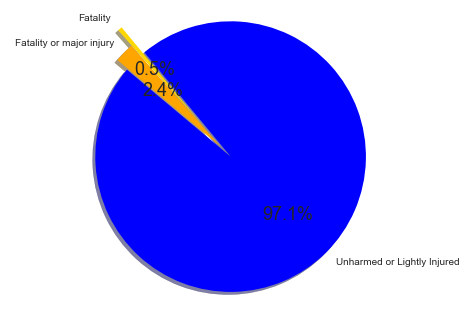

In [17]:
labels = 'Unharmed or Lightly Injured', 'Fatality','Fatality or major injury'
colors = [ 'blue','gold','orange']
explode = (0.1,0.15, 0)  # explode 1st slice
sizes = [crashs.loc[crashs.FATAL == 0, 'FATAL'].count(),crashs.loc[crashs.FATAL == 1, 'FATAL'].count(),crashs.loc[crashs.FATAL_OR_MAJ_INJ == 1, 'FATAL_OR_MAJ_INJ'].count()]
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
plt.rc("font", size=18) 
plt.axis('equal')
plt.savefig("fig/percentage_of_fatal_accident.png")
plt.show()

Among all the accidents happened in Allegheny County from 2004 to 2016, about 2.4% accidents cause fatality or major injury, and about 0.5% accidents involved fatality. In other word, every 200 crash happens, there will be at least one live being taken away. 

## Create dummy variables

In [18]:
Collision_dummy = pd.get_dummies(crashs['COLLISION_TYPE'], prefix=['Coll'])
Weekday_dummy = pd.get_dummies(crashs['DAY_OF_WEEK'], prefix=['Weekday'])
ILLUMINATION_dummy =pd.get_dummies(crashs['ILLUMINATION'],prefix=['ILLUMINATION'])
WEATHER_dummy = pd.get_dummies(crashs['WEATHER'],prefix=['WEATHER'])
crashs_reg = pd.concat([crashs, Collision_dummy,Weekday_dummy,ILLUMINATION_dummy,WEATHER_dummy], axis=1).drop(['COLLISION_TYPE','DAY_OF_WEEK','ILLUMINATION','WEATHER'],axis=1)
crashs_reg.head()

,FATAL,FATAL_OR_MAJ_INJ,VEHICLE_COUNT,DRIVER_16YR,DRIVER_17YR,DRIVER_65_74YR,DRIVER_75PLUS,AGGRESSIVE_DRIVING,DISTRACTED,DRINKING_DRIVER,HVY_TRUCK_RELATED,INTERSECTION,SPEEDING_RELATED,UNBELTED,FIRE_IN_VEHICLE,CELL_PHONE,['Coll']_Angle,['Coll']_Head-On,['Coll']_Hit Pedestrian,['Coll']_Hit_Fixed_Object,['Coll']_Not Collision,['Coll']_Rear-End,['Coll']_Rear-to-Rear,['Coll']_Sideswipe,['Coll']_Unknown,['Weekday']_Weekday,['Weekday']_Weekend,['ILLUMINATION']_Dark,"['ILLUMINATION']_Dark,no_street_lights","['ILLUMINATION']_Dark,street_lights",['ILLUMINATION']_Dawn,['ILLUMINATION']_Daylight,['ILLUMINATION']_Dusk,['ILLUMINATION']_Not Report,['WEATHER']_Fog,['WEATHER']_No_adverse_conditions,['WEATHER']_Rain,['WEATHER']_Rain_and_fog,['WEATHER']_Sleet,['WEATHER']_Sleet_and_fog,['WEATHER']_Snow,['WEATHER']_other
0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,2,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
4,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


After turnning catagorical variable into dummy variable, we drop one of the dummy variable in each catogory to aviod multi-colinnearity, and also drop 'FATAL_OR_MAJ_INJ' and 'FATAL' since they are not input variable.

## Feature Selection

### Drop Highly Correlated Variable
Firstly, we dropped 'FATAL' and 'FATAL_OR_MAJ_INJ' becuase 'FATAL' is the response variable, and 'FATAL_OR_MAJ_INJ' contians simmilar information as 'FATAL' so we are not using it.<br/>
And also we dropped "['Coll']_Unknown","['ILLUMINATION']_Not Report","['Weekday']_Weekend","['WEATHER']_other"] to aviod multi-colinnearity.

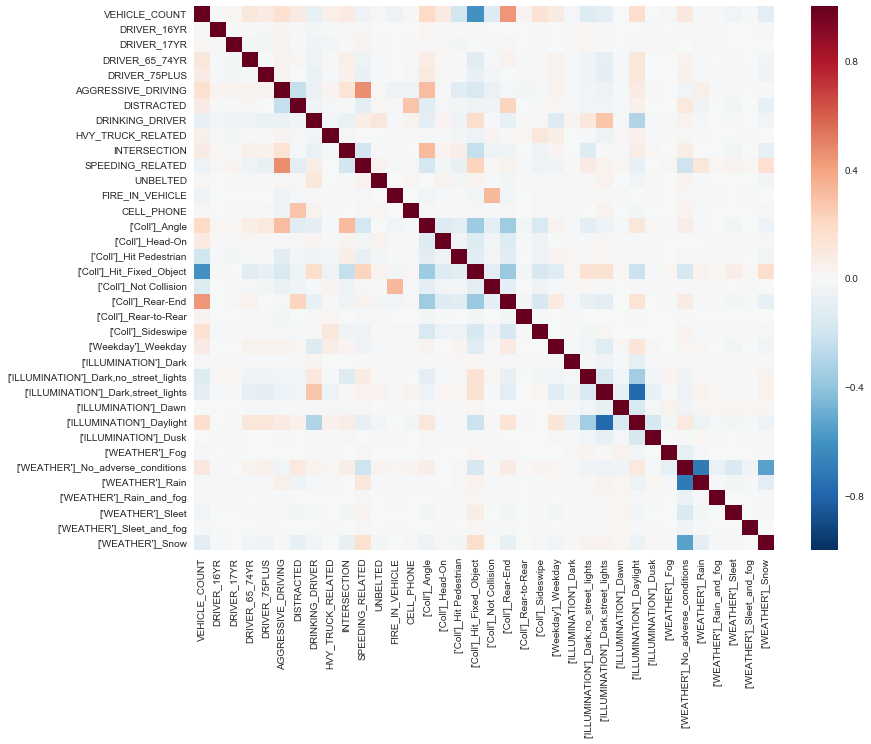

In [19]:
to_be_drop = ['FATAL','FATAL_OR_MAJ_INJ',"['Coll']_Unknown","['ILLUMINATION']_Not Report","['Weekday']_Weekend","['WEATHER']_other"]
raw_X = crashs_reg.drop(to_be_drop,axis=1)
plt.subplots(figsize=(13, 10))
sns.heatmap(raw_X.corr()) 
plt.savefig("fig/percentage_of_fatal_accident.png")
plt.show()

From the correlation map, we can see that *['ILLUMINATION']_Daylight* and *['ILLUMINATION']_Dark,street lights*, *['COLL']_Hit Fixed Object* and *VECHICLE_COUNT*,*['WEATHER']_No_adverse_conditions* and *['WEATHER']_Rain*, are highly correlated, so we decided to drop *['ILLUMINATION']_Dark,street lights*, *['COLL']_Hit Fixed Object*, and *['WEATHER']_No_adverse_conditions* variable.

In [20]:
drop_highly_corr = ["['ILLUMINATION']_Dark,street_lights", "['WEATHER']_No_adverse_conditions","['Coll']_Hit_Fixed_Object"] 

# Now we have our feature matrix X and response variable y
X=raw_X.drop(drop_highly_corr ,axis=1)
y = crashs_reg['FATAL_OR_MAJ_INJ']

## Logistic Regression Model Fitting

In [21]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.111945
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:       FATAL_OR_MAJ_INJ   No. Observations:               157821
Model:                          Logit   Df Residuals:                   157788
Method:                           MLE   Df Model:                           32
Date:                Wed, 13 Dec 2017   Pseudo R-squ.:                 0.01482
Time:                        07:42:55   Log-Likelihood:                -17667.
converged:                       True   LL-Null:                       -17933.
                                        LLR p-value:                 7.633e-92
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
VEHICLE_COUNT                             -2.1001   

If we set alpha = 0.05, most variables in the regression are statistically significant, besides 16,17-year-old drivers, CELL_PHONE, ['Coll']_Rear-to-Rear, ['ILLUMINATION']_Dark, ['WEATHER']_Sleet_and_fog sincr they have p-value that is more than 0.05. <br/>
To summarize, from the logistic regression, we find the following factors have significant impact on fatal accident <br/>

*human error:*
- use of alcohol
- wheather drivers involve in agressive driving behavior, like speeding
- wheather drivers were distracted
- wheather drivers were unbelted

<br/>*enviorment/other factors:*

- location of crash, such as intersection
- light and weather condition 
- time of crash
- number of vehicle involved
- age of drivers

## Evaluate Model using cross validation and confusion matrix

From previous analysis, we found that the fatality rate of car accident is roughly 0.5%, so we decided to randonly select 1/100 of nonfatal accidents to get samples which nonfatal accidents: fatal accident = 3 : 1

In [22]:
from sklearn.utils import shuffle
# select 1/100 nonfatal accidents
np.random.seed(1600)
nonfatal_sample= crashs_reg[crashs_reg.FATAL == 0].sample(frac=0.01, replace=True)
# select all fatal accidents
fatal_sample = crashs_reg[crashs_reg.FATAL == 1]
# merge nonfatal samples and fatal samples
sample= pd.concat([nonfatal_sample,fatal_sample],axis=0)
# get response variable ysample and regression matrix Xsample
ysample = sample['FATAL']
Xsample = sample.drop(to_be_drop,axis=1).drop(drop_highly_corr,axis=1)

After getting response variable ysample and regression matrix Xsample, we will split samples into trianning set and testing set, and then use confusion matrix to evaluate the accuracy of our model' prediction.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(Xsample, ysample, test_size=0.1, random_state=0)
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(LogReg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


Cross validation generalize independent dataset, we use cross-validation to "train" our data to avoid overfitting.

In [24]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
scoring = 'accuracy'
results = model_selection.cross_val_score(LogReg, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.790


The 10-flod cross validation have similiar accuracy compared to logistic regression classifier, so we concluded that our model do not have the problem of overfitting. Next, we want to use confusion matix to see how accurate our prediction is.

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[140,  19],
       [ 25,  59]])

The first row in the confusion matrix are samples of acutal non-fatal accidents in the testing set, and the second row are samples of fatal accidents. The first row are number of predicted non-fatal accidents, and the seconed row are number of predicted fatal accidents. <br/>
That being said, in the testing set, which consists of 243 samples, out of 159 non-fatal accidents, 140 prediction are correct; out of 84 fatal accidents, 59 predictions are correct. 140+ 59=199 out of 243 of our prediction are right.

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.85      0.88      0.86       159
          1       0.76      0.70      0.73        84

avg / total       0.82      0.82      0.82       243



From the classification report, if the model predicted it is a fatal accident, 82% of the time the prediction is right(precision), and if it is actually a fatal accident, 82% of the time it will predict a accident as a fatal accident(recall).  

## Summary
Logistic regression are usually used for classification and calculate probabilities of a prediction. Although logistic regression models are simple and often insufficient to fully capture relationships between variables in many predictive modeling tasks, it gives us information about which feature in the regression is significant to the reponse variable.
<br>
In the following notebooks, we will discuss how the features, which we found is significant in fatal accident, affect traffic safty. In notebook 2, we will use 10 year U.S. fatal accidents from NHTSA, and take out the important features that we obtained from this notebook. In notebook 3&4, we will analyze human error and the enviorment of fatal accidents, and in notebook5, we will analyze the role of alcohol in fatal accidents.